# Aplicação Redes Recorrentes - Forró Rasta Chinela

In [1]:
from rubianets import *

import re
from unidecode import unidecode
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Obtenção dos dados
Vamos coletar as letras das músicas a partir do site letras.mus.br e salvar para arquivo csv

In [111]:
import time
import os
import pandas as pd
from selenium import webdriver
from IPython.display import display, HTML, clear_output

CHROMEDRIVER = '/home/lazarop/opt/chromedriver'

OPTIONS = webdriver.ChromeOptions()
OPTIONS.add_argument('--ignore-certificate-errors')
OPTIONS.add_argument('--incognito')
OPTIONS.add_argument('--headless')


def getURL(url, class_name, timeout=3):
    driver = webdriver.Chrome(CHROMEDRIVER, options=OPTIONS)
    driver.get(url)
    time.sleep(timeout)
    objs = driver.find_elements_by_class_name(class_name)
    page_source = driver.page_source
    return objs, page_source

def build_songs_database(songs):
    database = []
    print('Building artist database')
    for song in songs:
        song_url = song.get_attribute('data-shareurl')
        song_id = song.get_attribute('data-id')
        song_title = song.get_attribute('data-name')
        song_artist = song.get_attribute('data-artist')
        database.append([song_artist, song_title, song_id, song_url])
        print([song_artist, song_title, song_id, song_url])
    database = pd.DataFrame(database)
    database.columns = ['artist','title','letras_id','letras_url']
    print('Found %d songs for this artist' % len(database))
    print(database.sample(3).T)
    return database

def get_song(url, pause):
    content = []
    lyrics, page = getURL(url, 'cnt-letra', timeout=pause)
    for strophe in lyrics[0].find_elements_by_css_selector("p"):
        for verse in strophe.text.split('\n'):
            content.append(verse)
    content = pd.DataFrame({'lyrics': content})
    content['letras_url'] = url
    return content

def crawl_artist(artist_url, pause=1, saveto='', minlen=5, maxlen=200):
    songs, page = getURL(artist_url, "cnt-list-row", pause)
    songs_database = build_songs_database(songs)
    for song_url in songs_database.letras_url:
        clear_output(wait=True)
        fname = saveto + song_url.split('/')[-2] + '.csv'
        if os.path.isfile(fname):
            print('File already exists:', fname)
        else:
            print('Downloading:', song_url)
            lyrics = get_song(song_url, pause)
            lyrics.to_csv(fname, index=False)
    lyrics_database = pd.DataFrame()
    for fname in os.listdir(saveto):
        if fname != 'songs.csv' and fname.endswith(".csv"):
            lyrics = pd.read_csv(saveto+fname)
            lyrics_database = pd.concat([lyrics_database, lyrics], axis=0)
            #print('Database shape:', lyrics_database.shape)
    database = pd.merge(songs_database, lyrics_database)
    database['length'] = database.lyrics.apply(lambda x: len(x))
    database.drop_duplicates(inplace=True)
    # algumas músicas estão mal escritas (sem separação de linhas grudando palavras, também símbolos de refrão)
    database = database.loc[(database.length>minlen)&(database.length<maxlen)] 
    database.to_csv(saveto + 'songs.csv', index=False)
    return songs_database, lyrics_database, database

In [112]:
# letras.com.br
artist_url = 'https://www.letras.mus.br/rasta-chinela/'

songs_database, lyrics_database, database = crawl_artist(artist_url, pause=1, saveto='dataset/rastachinela/')
database

File already exists: dataset/rastachinela/1902118.csv


,artist,title,letras_id,letras_url,lyrics,length
0,Rasta Chinela,Mel da Sua Boca,957811,https://www.letras.mus.br/rasta-chinela/957811/,Como é doce o beijo quando vem da sua boca,42
1,Rasta Chinela,Mel da Sua Boca,957811,https://www.letras.mus.br/rasta-chinela/957811/,Dá uma vontade de levar você comigo,35
2,Rasta Chinela,Mel da Sua Boca,957811,https://www.letras.mus.br/rasta-chinela/957811/,Na verdade isso nunca aconteceu é um mundo nov...,63
3,Rasta Chinela,Mel da Sua Boca,957811,https://www.letras.mus.br/rasta-chinela/957811/,"Ah! Eu nem sabia que isso existia, um amor tão...",65
4,Rasta Chinela,Mel da Sua Boca,957811,https://www.letras.mus.br/rasta-chinela/957811/,"Cuida de quem, baby, te ama demais",34
...,...,...,...,...,...,...
3108,Rasta Chinela,Vou Por Aí,1902118,https://www.letras.mus.br/rasta-chinela/1902118/,Meu desejo procurando outra emoção,34
3109,Rasta Chinela,Vou Por Aí,1902118,https://www.letras.mus.br/rasta-chinela/1902118/,Vou por aí (repete),19
3110,Rasta Chinela,Vou Por Aí,1902118,https://www.letras.mus.br/rasta-chinela/1902118/,Eu morro de amor por ela e ela nem aí,37
3111,Rasta Chinela,Vou Por Aí,1902118,https://www.letras.mus.br/rasta-chinela/1902118/,"Saudade rasgando o peito, pra onde ir?",38


In [113]:
database.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1553 entries, 0 to 3113
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist      1553 non-null   object
 1   title       1553 non-null   object
 2   letras_id   1553 non-null   object
 3   letras_url  1553 non-null   object
 4   lyrics      1553 non-null   object
 5   length      1553 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 84.9+ KB


## Preparação dos dados

In [266]:
def process_punctuation(otext, filters):
    text = otext.replace('...',',')
    discard = ['x','bis']
    text = re.sub(r'(['+filters+'])', r' \1 ', text)
    text = ' '.join([word for word in text.split() if len(word) > 0 and word != ' ' and not word.lower() in discard])
    text = text.replace(', .',',').replace('. .','.').replace('. ,','.') # acontece ao remover os discards
    return text

data = pd.read_csv('dataset/rastachinela/songs.csv')
corpus = np.array(data.lyrics)
print(corpus)

filters = "!?'#$%&()*+/:;<=>@[\\]^_`{|}~\t\n0123456789"
for i, text in enumerate(corpus):
    corpus[i] = process_punctuation(text, filters + ',.')

print('\nCorpus shape:', corpus.shape)
print('Sample:\n', np.array(corpus[0:5]))

['Como é doce o beijo quando vem da sua boca'
 'Dá uma vontade de levar você comigo'
 'Na verdade isso nunca aconteceu é um mundo novo que me apareceu' ...
 'Eu morro de amor por ela e ela nem aí'
 'Saudade rasgando o peito, pra onde ir?' 'Noite fria madrugada tô por aí']

Corpus shape: (1553,)
Sample:
 ['Como é doce o beijo quando vem da sua boca'
 'Dá uma vontade de levar você comigo'
 'Na verdade isso nunca aconteceu é um mundo novo que me apareceu'
 'Ah ! Eu nem sabia que isso existia , um amor tão lindo só você e eu'
 'Cuida de quem , baby , te ama demais']


In [267]:
def get_tokenizer(corpus, num_words, filters):
    oov_token = '' 
    tokenizer = Tokenizer(num_words=num_words, filters=filters)
    #tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token, filters=filters)
    tokenizer.fit_on_texts(corpus)
    vocab_size = len(tokenizer.word_index)
    word2idx = tokenizer.word_index
    idx2word = {v: k for (k, v) in word2idx.items()}
    print('Found %d vocab compared to an allowed %d size' % (vocab_size, num_words))
    if vocab_size > num_words:
        print('Discarding a total of %d less frequent words' % (vocab_size - num_words))
    print('Word counts: %s' % (list(tokenizer.word_counts.items())[:5]))
    print('Most commom words: %s' % (list(tokenizer.word_index.items())[:5]))
    sizes = [len(x) for x in corpus]
    print('Longest sentence (chars+/-std): %d (%d+/-%d)' % (max(sizes), int(np.mean(sizes)), int(np.std(sizes))))
    words = [len(x.split()) for x in corpus]
    print('Longest sentence (words+/-std): %d (%d+/-%d)' % (max(words), int(np.mean(words)), int(np.std(words))))
    return vocab_size, tokenizer, word2idx, idx2word


max_vocab, max_len, embedding_dim = 1800, 10, 256

vocab_size, tokenizer, word2idx, idx2word = get_tokenizer(corpus, max_vocab, filters)

Found 1750 vocab compared to an allowed 1800 size
Word counts: [('como', 22), ('é', 155), ('doce', 3), ('o', 195), ('beijo', 6)]
Most commom words: [(',', 1), ('que', 2), ('eu', 3), ('não', 4), ('e', 5)]
Longest sentence (chars+/-std): 130 (29+/-12)
Longest sentence (words+/-std): 30 (6+/-3)


In [268]:
def use_tokenizer(tokenizer, corpus):
    sequences = tokenizer.texts_to_sequences(corpus)
    print('\nTokenized (example):')
    print(corpus[0], ' -> ', sequences[0])
    return sequences

def process_corpus(seqs, idx2word):
    res_seqs = []
    for seq in seqs:
        for i in range(len(seq)):
            amplified = [seq[j] for j in range(i+1)]
            if len(amplified) > 1: res_seqs.append(amplified)
    print('\nDomain amplified: %d before processing -> %d final corpus length' % (len(seqs), len(res_seqs)))
    print('\nPrepared (example):', seq)
    print(' '.join([idx2word[idx] for idx in seq]))
    for sliced in res_seqs[-len(seq)+1:]:
        print(sliced, ' '.join([idx2word[idx] for idx in sliced]))
    return res_seqs


corpus_seqs = use_tokenizer(tokenizer, corpus)
proc_corpus = process_corpus(corpus_seqs, idx2word)
max_corpus = np.max([len(xi) for xi in proc_corpus])
print('\nMax corpus length:', max_corpus)


Tokenized (example):
Como é doce o beijo quando vem da sua boca  ->  [59, 9, 368, 8, 212, 39, 48, 37, 81, 125]

Domain amplified: 1553 before processing -> 8162 final corpus length

Prepared (example): [97, 1750, 482, 54, 25, 135]
noite fria madrugada tô por aí
[97, 1750] noite fria
[97, 1750, 482] noite fria madrugada
[97, 1750, 482, 54] noite fria madrugada tô
[97, 1750, 482, 54, 25] noite fria madrugada tô por
[97, 1750, 482, 54, 25, 135] noite fria madrugada tô por aí

Max corpus length: 30


In [269]:
def align_sentences(sequences, maxlen, padding, truncating):
    return pad_sequences(sequences, maxlen=maxlen+1, padding=padding, truncating=truncating)

def prepare_dataset(corpus, max_vocab, filters, punct, max_len):
    if not punct: filters = filters + ',.'
    vocab_size, tokenizer, word2idx, idx2word = get_tokenizer(corpus, max_vocab, filters)
    corpus_seqs = use_tokenizer(tokenizer, corpus)
    proc_corpus = process_corpus(corpus_seqs, idx2word)
    dataset = align_sentences(proc_corpus, max_len, 'pre', 'pre')
    print('\nDataset shape:', dataset.shape)
    print(dataset[-10:])
    X = np.array(dataset[:,:-1])
    y = dataset[:,-1]
    y = keras.utils.to_categorical(y, num_classes=max_vocab)
    print('\nDataset shape X | y:', X.shape, y.shape)
    return X, y, tokenizer, word2idx, idx2word


max_vocab, max_len, embedding_dim = vocab_size, 10, 256
X, y, tokenizer, word2idx, idx2word = prepare_dataset(corpus, max_vocab, filters, False, max_len)

Found 1748 vocab compared to an allowed 1750 size
Word counts: [('como', 22), ('é', 155), ('doce', 3), ('o', 195), ('beijo', 6)]
Most commom words: [('que', 1), ('eu', 2), ('não', 3), ('e', 4), ('de', 5)]
Longest sentence (chars+/-std): 130 (29+/-12)
Longest sentence (words+/-std): 30 (6+/-3)

Tokenized (example):
Como é doce o beijo quando vem da sua boca  ->  [57, 8, 366, 7, 210, 37, 46, 35, 79, 123]

Domain amplified: 1553 before processing -> 7511 final corpus length

Prepared (example): [95, 1748, 480, 52, 23, 133]
noite fria madrugada tô por aí
[95, 1748] noite fria
[95, 1748, 480] noite fria madrugada
[95, 1748, 480, 52] noite fria madrugada tô
[95, 1748, 480, 52, 23] noite fria madrugada tô por
[95, 1748, 480, 52, 23, 133] noite fria madrugada tô por aí

Dataset shape: (7511, 11)
[[   0    0    0    0    0    0    0    0   65 1747    7]
 [   0    0    0    0    0    0    0   65 1747    7  180]
 [   0    0    0    0    0    0   65 1747    7  180   12]
 [   0    0    0    0    0 

## Treinamento da rede neural

In [270]:
gpu = True
workers = 10
batch_size, epochs, dropout, timeout = 32, 300, 0.0, 5

optimizers = {'adam': Adam(lr=1e-3, decay=1e-3/epochs), 'adam_fast': Adam(lr=1e-1, decay=1e-1/epochs), 
              'rmsprop': RMSprop(lr=1e-3, rho=0.9, momentum=0.0), 'rmsprop_fast': RMSprop(lr=1e-1, rho=0.9, momentum=0.0),
              'sgd': SGD(lr=1e-3, momentum=0.9), 'sgd_fast': SGD(lr=1e-1, momentum=0.9)}
models = {'RNN1': RecurrentOne, 'RNN2': RecurrentTwo,
          'RNN3': RecurrentThree, 'RNN4': RecurrentFour}

grid = []
for vs in [vocab_size]:
    for ed in [256]:
        for punct in [True]:
            #for opt in ['adam','adam_fast','sgd','sgd_fast','rmsprop','rmsprop_fast']:
            for opt in ['adam']:
                for lstm in [256]:
                    for ml in [10]:
                        #for m in ['RNN4', 'RNN3', 'RNN2', 'RNN1']:
                        for m in ['RNN1']:
                            grid.append({'model': m, 'vocab': vs, 'embeddings': ed, 'maxlen': ml,
                                         'lstm': lstm, 'punct': punct, 'optimizer': opt})
                            
print('Up to %.1f hours to complete those %d trainings' % ((len(grid)*timeout/60), len(grid)))

Up to 0.1 hours to complete those 1 trainings


In [271]:
results = {}
best_model, best_history, best_accuracy, best_key = None, None, 0, 0
start = time.time()

for i, search in enumerate(grid):
    report = ''
    if i > 0: 
        report += 'OVERALL:\nBest accuracy: %.1f%%\n' % (100*best_accuracy)
        report += 'Setup: %s\n' % str(best_model)
        report += '\nETA (hours): %.2f\n' % ((len(grid)-i)*(time.time()-start)/i/60/60)
    report += '\nRunning experiment %d of %d (%.1f%%)\n' % (i+1, len(grid), 100*i/len(grid))
    report += 'Setup: %s\n' % str(search)
    
    X, y, tokenizer, word2idx, idx2word = prepare_dataset(corpus, search['vocab'], filters, 
                                                          search['punct'], search['maxlen'])

    k = simplerKeras(X=X, y=y, gpu=gpu, workers=workers, gpu_test=False)

    model = models[search['model']].build(input_dim=search['vocab'], output_dim=search['embeddings'], 
                                  input_len=search['maxlen'], lstm_out=search['lstm'], dropout=dropout,
                                  classes=search['vocab'], reg=l2(0.0005), last_act='softmax')
    model.compile(loss="categorical_crossentropy", optimizer=optimizers[search['optimizer']], metrics=["accuracy"])
    model.summary()

    checkpoint = time.time()
    history = model.fit(k.X, k.y, epochs=epochs, batch_size=batch_size, verbose=0, 
                        workers=k.workers, use_multiprocessing=k.multicore,
                        callbacks=[formatCallbackNotebook(epochs,checkpoint,report,timeout)])

    loss, acc = np.mean(history.history['loss'][-5:]), np.mean(history.history['accuracy'][-5:])
    results[i] = {'id':i+1, 'model': search['model'], 'vocab': search['vocab'], 
                  'embeddings': search['embeddings'], 'maxlen': search['maxlen'], 'lstm': search['lstm'], 
                  'punct': search['punct'], 'optimizer': search['optimizer'],
                  'loss': loss, 'acc': acc, 'epochs': len(history.history['loss']),
                  'elapsed_time': time.time()-checkpoint}

    if acc > best_accuracy:
        best_model = search
        best_history = history
        best_accuracy = acc
        best_key = i
    if i + 1 < len(grid):
        del model
        k.release()
        del k


Results:
Constant parameters: maxlen (10), lstm (256), max_epochs (300)


,id,model,vocab,embeddings,maxlen,lstm,punct,optimizer,loss,acc,epochs,elapsed_time,timeout,max_epochs
0,4,RNN1,1752,256,10,256,True,adam,0.4773,0.8451,55,181.7744,3,300
1,2,RNN3,1752,256,10,256,True,adam,0.5127,0.8449,46,180.5454,3,300
2,1,RNN4,1751,256,10,256,True,adam,0.4735,0.8445,57,300.4125,5,300
3,12,RNN1,1752,256,10,256,True,sgd_fast,0.4965,0.8438,78,180.0640,3,300
4,3,RNN2,1752,256,10,256,True,adam,0.5217,0.8422,33,183.9508,3,300
5,10,RNN3,1752,256,10,256,True,sgd_fast,0.5219,0.8408,56,181.9011,3,300
6,1,RNN4,1752,256,10,256,True,adam,0.5082,0.8405,33,184.9722,3,300
7,11,RNN2,1752,256,10,256,True,sgd_fast,0.5509,0.8401,36,181.2740,3,300
8,9,RNN4,1752,256,10,256,True,sgd_fast,0.5176,0.8398,41,182.4295,3,300
9,8,RNN1,1752,256,10,256,True,adam_fast,0.5718,0.8353,54,181.2597,3,300


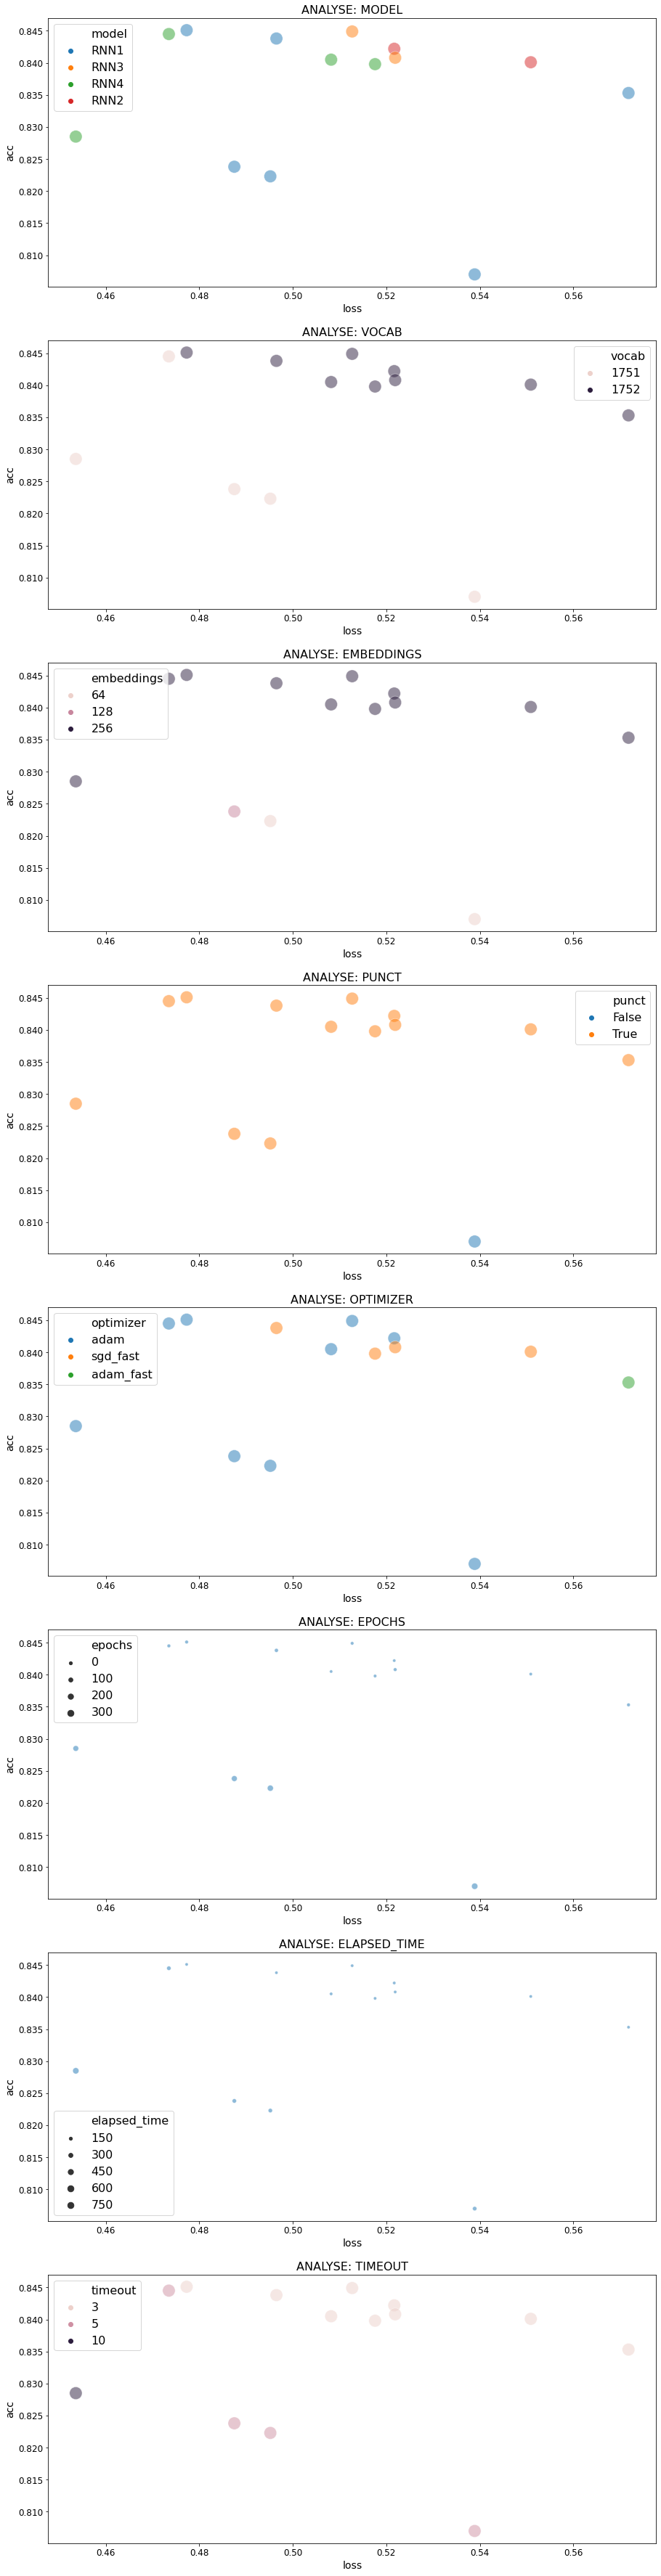

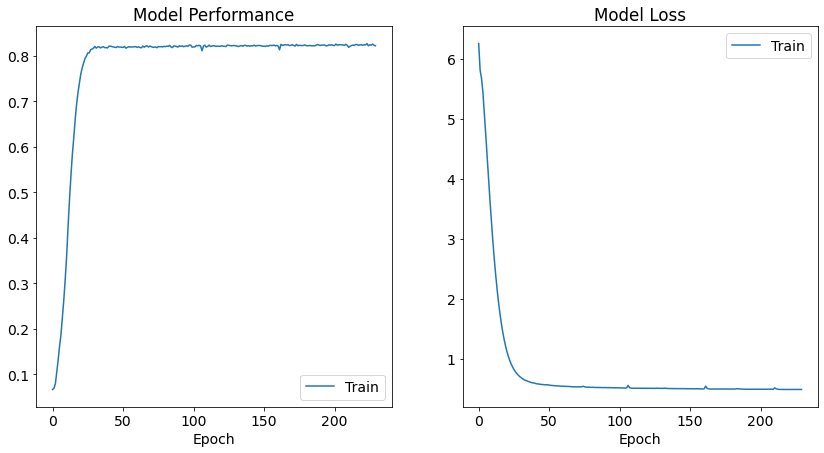

In [236]:
def printQuadrants(results, epochs, timeout, min_acc=0.0):
    print('\nResults:')
    #print('Training restrictions: %.0f max minutes and %d max epochs per training' % (timeout, epochs))
    aux = pd.DataFrame.from_dict(results, orient='index')
    aux['timeout'] = timeout
    aux['max_epochs'] = epochs
    df = pd.read_csv('dataset/results_br.csv')
    #df = pd.DataFrame()
    df = pd.concat([df, aux], axis=0)
    for col in ['acc','loss','elapsed_time']:
        df[col] = df[col].apply(lambda x: round(x, 4)) 
    df = df.drop_duplicates().reset_index(drop=True)
    df.sort_values(by='acc', inplace=True, ascending=False)
    df.to_csv('dataset/results_br.csv', index=False)
    df = df.loc[df.acc >= min_acc]

    cols_analyse = [cols for cols in df.columns if not cols in [x] + [y] + ign]
    remarks, graphs = [], []
    for col in cols_analyse:
        if len(df[col].unique()) > 1:
            graphs.append([x, y, col])
        else:
            remarks.append('%s (%s)' % (col, str(df[col].iloc[0])))

    if len(remarks) > 0: print('Constant parameters:', ', '.join(remarks))

    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(figsize=(15, 8*len(graphs)), nrows=len(graphs))    
    for i, cols in enumerate(graphs):
        aux = df[cols].copy()
        names = aux.columns
        if len(aux[names[2]].unique()) <= 10:
            sns.scatterplot(x=names[0] ,y=names[1], hue=names[2], data=aux, alpha=0.5, 
                            ax=axes[i], s=300, legend='full')  
        else:
            sns.scatterplot(x=names[0] ,y=names[1], size=names[2], data=aux, alpha=0.5, 
                            ax=axes[i], s=300)  
        axes[i].tick_params(axis='both', labelsize=12)
        axes[i].tick_params(axis='both', labelsize=12)
        axes[i].set_title(('Analyse: %s' % names[2]).upper(), size=16)
        axes[i].legend(fontsize=16)
    plt.plot()
    display(df)
    
def printHistory(history, metric='accuracy'):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (14, 7))
    axs[0].plot(history[metric], label='Train')
    axs[0].set_xlabel('Epoch')
    axs[0].set_title('Model Performance')
    axs[0].legend()
    axs[1].plot(history['loss'], label='Train')
    axs[1].set_xlabel('Epoch')
    axs[1].set_title('Model Loss')
    axs[1].legend()
    plt.show() 
    
    
x, y, ign = 'loss', 'acc', ['id', 'loss']

printQuadrants(results, epochs, timeout, min_acc=0.80)
    
printHistory(best_history.history, metric='accuracy')

## Predição à la Rasta Chinela

'e'

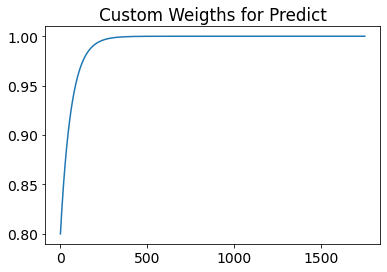

In [336]:
def select_predicted(probs):
    rnd = np.random.random() * np.sum(probs)
    i, cumsum = 0, 0
    while cumsum <= rnd:
        cumsum += probs[i]
        i += 1
    return i-1

def define_weights(size, cap=0.1, force=100):
    w = [1-cap*cap**(i/force) for i in range(size)]
    return w
    
def get_next_word(model, seed, idx2word, weigths, length):
    sequences = tokenizer.texts_to_sequences([seed])
    padded = pad_sequences(sequences, maxlen=length , padding='pre', truncating='pre')
    #predicted = model.predict_classes(padded)
    probs = model.predict(padded).flatten() * weigths
    predicted = select_predicted(probs)
    return str(idx2word[predicted]) #output_word
    
weigths = define_weights(k.y.shape[1], cap=0.2, force=100)
plt.plot(weigths)
plt.title('Custom Weigths for Predict')
plt.plot()

get_next_word(model, 'Com a sanfona na mão', idx2word, weigths, max_len)  

In [346]:
def format_text(text):
    words = [word.strip() for word in text.split()]
    text = ' '.join([word for i, word in enumerate(words) 
                     if (word in [',','.'] and not words[i-1] in [',','.']) 
                     or (not word in [',','.'] and not word == words[i-1])])
    text = text.replace(' , ',', ').replace(' . ','.\n').replace(' .','\n').replace('. ','.\n')
    text = text.replace(' s ',"'s ").replace(' d ',"'d ").replace(' i ',' I ')
    text = '.\n'.join([sentence[0].upper()+sentence[1:] for sentence in text.split('.\n')])
    return text

generate_words = 50

for song in range(10):
    #sentence = 'Na madrugada, a cachaça e a sanfona'
    #sentence = 'A cachaça é'
    #sentence = 'Quando a sanfona chora'
    sentence = 'Quando a sanfona chorona fala'
    for i in range(generate_words):
        predicted = get_next_word(model, sentence, idx2word, weigths, max_len)
        if predicted != sentence.split(' ')[-1]:
            sentence = sentence + " " + get_next_word(model, sentence, idx2word, weigths, max_len)

    #print(sentence)
    sentence = format_text(sentence)
    print('\nNew Song #%d:' % (song+1))
    print(sentence)


New Song #1:
Quando a sanfona chorona fala que voce perdeu.
Fica tudo que e por você, eu estou aqui, vou me embriagar, tô ficando velho, meu dia sem dizer, mas que voce teve um coisa, amor, eu tiro a te ver, me saudade, te

New Song #2:
Quando a sanfona chorona fala que eu me noite e eu vou ama, mas voce, se chorar, eu estou se arrepender mal, pra falar se gabar.
E tudo o fim de guarda prejuízo.
Passada encanto, vivo.
Mais minha.
Tô ficando

New Song #3:
Quando a sanfona chorona fala que voce doi aqui do seu.
É o que eu, eu fiquei assim.
É

New Song #4:
Quando a sanfona chorona fala que voce eu traz.
Me dizer que eu não te perdi, não, te perdi, te adoro pra você esta vez, tudo que te consigo.
Mas que me ser um amor a peito coração na roupa


New Song #5:
Quando a sanfona chorona fala que voce é um mundo.
E me deixar lembrar quando ela diferente, vivo, e tudo burro apagar.
Tô tanto fazer, for, tudo que não era te amar, não estou te amar, quando seu amor se mim, que quem te fez

New Son